In [ ]:
# Install dependencies
!pip install opencv-python opencv-contrib-python matplotlib

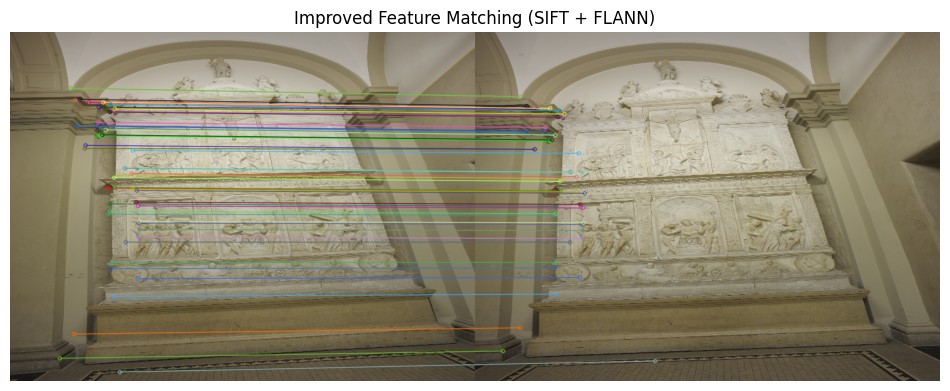

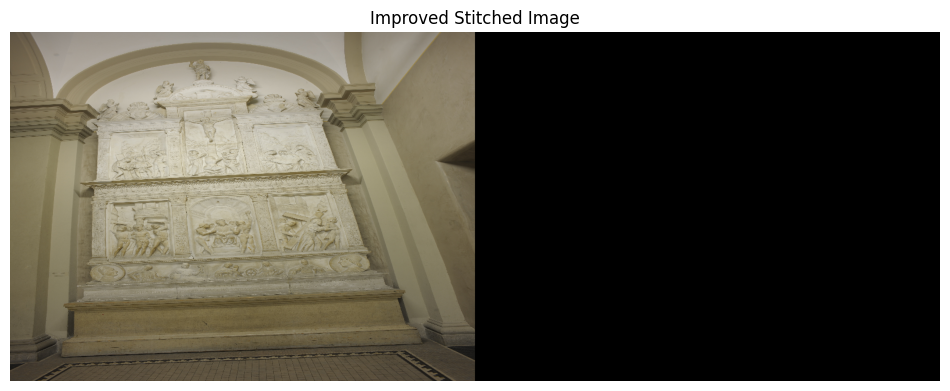

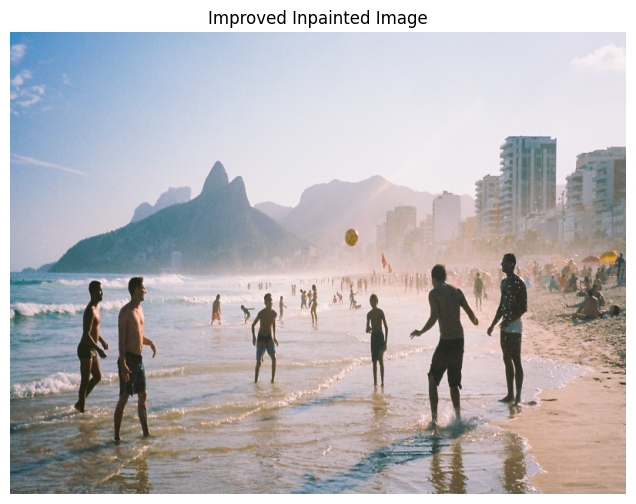

In [ ]:
#TASK 1 TEMP
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and resize
img_left = cv2.imread("L.jpg")
img_right = cv2.imread("R.jpg")
img_noisy = cv2.imread("noisy_image.png")
img_left = cv2.resize(img_left, (800, 600))
img_right = cv2.resize(img_right, (800, 600))
img_noisy = cv2.resize(img_noisy, (800, 600))

# ========== Feature Matching (SIFT + FLANN) ==========
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_left, None)
kp2, des2 = sift.detectAndCompute(gray_right, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

img_matches = cv2.drawMatches(img_left, kp1, img_right, kp2, good_matches[:50], None, flags=2)

# ========== Homography + Stitching ==========
# ========== Improved Stitching ==========
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp left image
h1, w1 = img_left.shape[:2]
h2, w2 = img_right.shape[:2]
warp_img = cv2.warpPerspective(img_left, H, (w1 + w2, max(h1, h2)))

# Paste right image
warp_img[0:h2, 0:w2] = img_right

# Blend overlapping region (simple feathering)
overlap_start = w2 - 100  # adjust based on estimated overlap
for i in range(overlap_start, w2):
    alpha = (i - overlap_start) / 100.0
    warp_img[:, i] = cv2.addWeighted(img_right[:, i], 1 - alpha, warp_img[:, i], alpha, 0)

stitched_img = warp_img

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and resize
img_left = cv2.imread("L.jpg")
img_right = cv2.imread("R.jpg")
img_noisy = cv2.imread("noisy_image.png")
img_left = cv2.resize(img_left, (800, 600))
img_right = cv2.resize(img_right, (800, 600))
img_noisy = cv2.resize(img_noisy, (800, 600))

# ========== Feature Matching (SIFT + FLANN) ==========
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_left, None)
kp2, des2 = sift.detectAndCompute(gray_right, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

img_matches = cv2.drawMatches(img_left, kp1, img_right, kp2, good_matches[:50], None, flags=2)

# ========== Homography + Stitching ==========
# ========== Improved Stitching ==========
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp left image
h1, w1 = img_left.shape[:2]
h2, w2 = img_right.shape[:2]
warp_img = cv2.warpPerspective(img_left, H, (w1 + w2, max(h1, h2)))

# Paste right image
warp_img[0:h2, 0:w2] = img_right

# Blend overlapping region (simple feathering)
overlap_start = w2 - 100  # adjust based on estimated overlap
for i in range(overlap_start, w2):
    alpha = (i - overlap_start) / 100.0
    warp_img[:, i] = cv2.addWeighted(img_right[:, i], 1 - alpha, warp_img[:, i], alpha, 0)

stitched_img = warp_img

# ========== Improved Inpainting: Patch-based with Texture Awareness ==========

# Step 1: Create texture map using gradient magnitude (structure tensor approx.)
gray = cv2.cvtColor(img_noisy, cv2.COLOR_BGR2GRAY)
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
magnitude = cv2.magnitude(grad_x, grad_y)
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
magnitude = np.uint8(magnitude)

# Invert magnitude: flat areas are white, textured are black
texture_map = 255 - magnitude

# Threshold to isolate flat areas only
_, flat_mask = cv2.threshold(texture_map, 180, 255, cv2.THRESH_BINARY)

# Morphological cleaning
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
flat_mask = cv2.morphologyEx(flat_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Remove small noisy regions
contours, _ = cv2.findContours(flat_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 200 or area > 3000:
        cv2.drawContours(flat_mask, [cnt], 0, 0, -1)

# Step 2: Combine with user-defined noisy zones (if known)
# Use Laplacian to detect potential damaged edges (like noise artifacts)
lap = cv2.Laplacian(gray, cv2.CV_64F)
lap = np.uint8(np.absolute(lap))
_, noise_zones = cv2.threshold(lap, 30, 255, cv2.THRESH_BINARY)

# Combine both to get a more intelligent mask
final_mask = cv2.bitwise_and(noise_zones, flat_mask)

# Optional visual debug
# cv2.imwrite("final_mask_debug.png", final_mask)

# Step 3: Apply patch-based inpainting (Navier-Stokes preferred here)
inpainted_img = cv2.inpaint(img_noisy, final_mask, 5, cv2.INPAINT_NS)





show_img(img_matches, "Improved Feature Matching (SIFT + FLANN)")
show_img(stitched_img, "Improved Stitched Image")
show_img(inpainted_img, "Improved Inpainted Image")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1217 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg PSNR: 10.411523


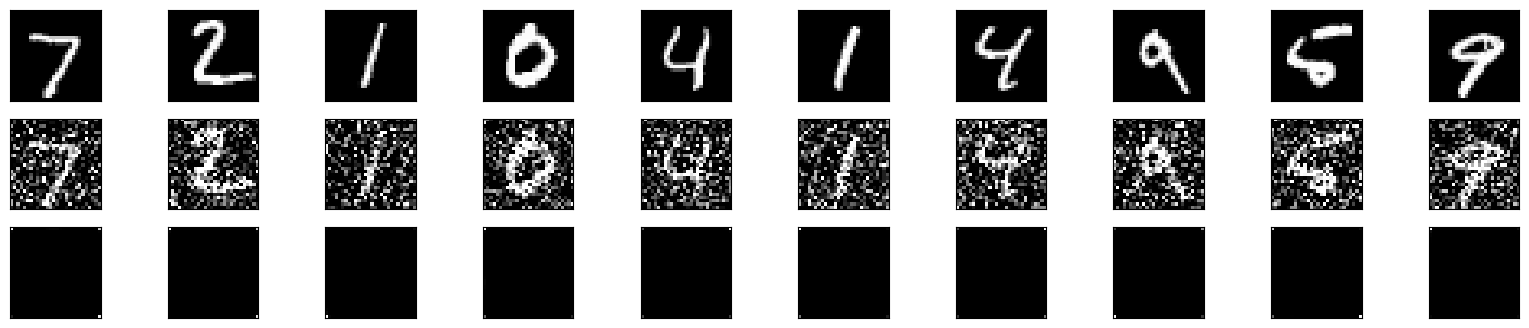


[INFO] Task 2 - Autoencoder Denoising Completed Successfully


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# -------- AUTOENCODER IMAGE RESTORATION --------
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add Gaussian noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Autoencoder architecture
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, x)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Predict
decoded_imgs = autoencoder.predict(x_test_noisy)

# PSNR Evaluation
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

psnr_scores = [psnr(x_test[i], decoded_imgs[i]) for i in range(10)]
print("Avg PSNR:", np.mean(psnr_scores))

# Display original, noisy, and restored
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\n[INFO] Task 2 - Autoencoder Denoising Completed Successfully")
